In [ ]:
# Import packages
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Import packages
%reset -f
import torchvision
import pprint
import os
import gzip
import numpy as np
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
from tqdm import tqdm

In [ ]:
def load_mnist(path, kind='train'):
    '''
    Load MNIST data from specified path
    '''
    
    labels_path = os.path.join(path,
                               '%s-labels-idx1-ubyte.gz'
                               % kind)
    images_path = os.path.join(path,
                               '%s-images-idx3-ubyte.gz'
                               % kind)

    with gzip.open(labels_path, 'rb') as lbpath:
        labels = np.frombuffer(lbpath.read(), dtype=np.uint8,
                               offset=8)

    with gzip.open(images_path, 'rb') as imgpath:
        images = np.frombuffer(imgpath.read(), dtype=np.uint8,
                               offset=16).reshape(len(labels), 784)

    return images, labels

In [ ]:
def _filter(xs, ys, lbls):
    '''
    Filter observations to construct relevant dataset
    '''
    idxs = [i for (i, l) in enumerate(ys) if l in lbls]
    return xs[idxs, :], ys[idxs]

In [ ]:
def clear_gpu(model):
   '''
   Removes model from GPU and clears memory
   '''
   model = model.to('cpu')
   del model
   torch.cuda.empty_cache()

In [ ]:
class Dataset(torch.utils.data.Dataset):
    '''
    Basic dataset class to work with Torch data loader
    '''
    def __init__(self, X, y):
        self.X = X
        self.y = y
        
        # No. of rows in feature array should equal no. of examples
        assert len(X) == len(y), print("Number of examples don't match up")

    def __len__(self):
        return len(self.X)

    def __getitem__(self, index):
        return self.X[index], self.y[index]

In [ ]:
class Net(torch.nn.Module):
  '''
  Basic convolutional neural network class
  '''
  def __init__(self):
    '''
    Architecture definition
    '''
    super(Net, self).__init__()
    self.conv1 = torch.nn.Conv2d(1, 6, kernel_size=3, stride=1, padding=1)
    self.pool = torch.nn.MaxPool2d(2, 2)
    self.conv2 = torch.nn.Conv2d(6, 16, 5)
    self.fc1 = torch.nn.Linear(16 * 5 * 5, 120)
    self.fc2 = torch.nn.Linear(120, 84)
    self.fc3 = torch.nn.Linear(84, 5)
  
  def forward(self, x):
    '''
    Forward propagation
    '''
    x = self.pool(F.relu(self.conv1(x)))
    x = self.pool(F.relu(self.conv2(x)))
    x = x.view(-1, 16 * 5 * 5)
    x = F.relu(self.fc1(x))
    x = F.relu(self.fc2(x))
    x = self.fc3(x) 
    
    return x

In [ ]:
def get_data(dataloader_params, path='/content/drive/MyDrive/data'): 
    '''
    Prepare data
    '''
    # Load data
    train_images, train_labels = load_mnist(path, 'train')
    test_images, test_labels = load_mnist(path, 't10k')
    
    # Validation images
    val_images = train_images[50000:]
    val_labels = train_labels[50000:]
    
    # Train images
    train_images = train_images[:50000]
    train_labels = train_labels[:50000]
    
    # Filter the relevant images according to the problem specification
    X_train, Y_train = _filter(train_images, train_labels, [0, 1, 4, 5, 8])
    X_val, Y_val = _filter(val_images, val_labels, [0, 1, 4, 5, 8])
    X_test, Y_test = _filter(test_images, test_labels, [0, 1, 4, 5, 8])

    for Y in [Y_train, Y_val, Y_test]:
      Y[Y == 4] =  2
      Y[Y == 5] =  3
      Y[Y == 8] =  4
    
    # Reshape data into 28 X 28 format
    X_train = X_train.reshape(X_train.shape[0], 28, 28)
    X_test = X_test.reshape(X_test.shape[0], 28, 28)
    X_val = X_val.reshape(X_val.shape[0], 28, 28)
    
    # Add new axis to to make sure 
    X_train = X_train[:, np.newaxis, :, :]
    X_test = X_test[:, np.newaxis, :, :]
    X_val = X_val[:, np.newaxis, :, :]
    
    # Dataset
    train_data = Dataset(X_train, Y_train)
    train_generator = torch.utils.data.DataLoader(train_data, **dataloader_params)
    
    # Convert into torch tensors and send to device
    X_train = torch.from_numpy(X_train).type(torch.FloatTensor)
    Y_train = torch.Tensor(Y_train).type(torch.LongTensor)
    
    # Convert into torch tensors and send to device
    X_val = torch.from_numpy(X_val).type(torch.FloatTensor)
    Y_val = torch.Tensor(Y_val).type(torch.LongTensor)
    
    # Convert into torch tensors and send to device
    X_test = torch.from_numpy(X_test).type(torch.FloatTensor)
    Y_test = torch.Tensor(Y_test).type(torch.LongTensor)
    
    # Return statement
    return(train_generator, X_train, Y_train, X_val, Y_val, X_test, Y_test)

In [ ]:
def train(question_no, model_num, epochs=30, batch_size=32, lr=0.1, weight_decay=0, test=False):
    '''
    Main training loop for convolutional network
    '''
    # Set the seed so each experiment is reproducible
    np.random.seed(21390)
    torch.manual_seed(10394)

    # Set parameters
    dataloader_params = {'batch_size': batch_size, 'shuffle': True, 'num_workers': 6}
    epochs = epochs
  
    # Store results here
    history = {
        'train_accuracy': [],
        'train_loss': [], 
        'val_accuracy': [],
        'val_loss': []
    }
  
    # Load data
    train_generator, X_train, Y_train, X_val, Y_val, X_test, Y_test = get_data(dataloader_params)
  
    # Set device
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

    # Send all these objects to the relevant device
    X_train = X_train.to(device)
    Y_train = Y_train.to(device)

    # Validation set to GPU
    X_val = X_val.to(device)
    Y_val = Y_val.to(device)

    # Testing set to GPU
    X_test = X_test.to(device)
    Y_test = Y_test.to(device)

    # Create the neural network objects and parameters
    net = Net().to(device)
  
    # Loss function
    loss_fn = torch.nn.CrossEntropyLoss()
    
    # Optimizer
    optimizer = torch.optim.Adam(net.parameters(), lr = lr, weight_decay=weight_decay)


    if not test:

        min_val_loss = 999999999
      
        # Train for maximum number of epochs given here
        for epoch in tqdm(range(epochs)):
      
            # Initialize running loss value for this epoch
            running_loss = 0.0
      
            # Loop through the generator containing training images
            for i, data in enumerate(train_generator):

              # Retrieve inputs and labels
              inputs, labels = data

              # Send them to GPU 
              inputs = inputs.type(torch.FloatTensor).to(device)
              labels =  labels.type(torch.LongTensor).to(device)

              # Zero the optimizer gradients
              optimizer.zero_grad()

              # Forward propagation
              outputs = net.forward(inputs)

              # Compute loss
              loss = loss_fn(outputs, labels)
          
              # Backward propogation
              loss.backward()

              # Weight update
              optimizer.step()
      
            # Compute training loss
            with torch.no_grad():
          
              # Forward propagation
              out = net.forward(X_train)

              # Prediction 
              preds = out.argmax(axis=1)

              # Get accuracy 
              accuracy = sum(preds == Y_train)/len(Y_train)
          
              # Get loss 
              loss = loss_fn(out, Y_train)

              print("Train accuracy {}, Train Loss: {}".format(accuracy, loss))

              # Append to history record
              history['train_accuracy'].append(accuracy)
              history['train_loss'].append(loss)

          
            # Compute validation loss
            with torch.no_grad():
        
              # Forward propogation
              out = net.forward(X_val)

              # Prediction 
              preds = out.argmax(axis=1)
        
              # Calculate accuracy
              accuracy = sum(preds == Y_val)/len(Y_val)

              # Calculate loss 
              loss = loss_fn(out, Y_val)

              # Print statement
              print("Val. accuracy {}, Val. Loss:, {}".format(accuracy, loss))
        
              # Append to history record
              history['val_accuracy'].append(accuracy)
              history['val_loss'].append(loss)

            if loss < min_val_loss:
          
              model_state = {
                    'epoch': epoch,
                    'model_state_dict': net.state_dict(),
                    'optimizer_state_dict': optimizer.state_dict(),
                    'history': history
                    }
          
              save_checkpoint(model_state, question_no, model_num)

              min_val_loss = loss
    

        # Plot and save epoch by epoch results
        plot_results(history, 'loss', model_num=model_num)
        plot_results(history, 'accuracy', model_num=model_num)

        # Return statement
        return(history)
        
    # If the test flag is True we execute this
    if test:

        # First use helper function given below to load checkpoints file
        checkpoint = load_checkpoint(question_no = question_no, model_num=model_num)

        # Load model state dictionary
        net.load_state_dict(checkpoint['model_state_dict'])
        
        # Load optimizer state dictionary
        optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
        
        # Set model to evaluation mode to make sure any batch norm and dropout layers are set correctly
        net.eval()

        # Now do the testing process
        with torch.no_grad():
        
            # Forward propogation
            out = net.forward(X_test)
        
            # Prediction 
            preds = out.argmax(axis=1)
        
            # Calculate accuracy
            accuracy = sum(preds == Y_test)/len(Y_test)
        
            # Calculate loss 
            loss = loss_fn(out, Y_test)

            # Print success message
            print("Testing completed! Saving results now...")

            # Print accuracy 
            print(accuracy)

            # Print losss
            print(loss)
        
            # Append to history record
            checkpoint['test_accuracy'] = accuracy
        
            # Append loss to history record
            checkpoint['test_loss'] = loss

        # Return statement    
        return(preds, Y_test, X_test)

In [ ]:
def plot_results(history, lab, model_num, path='/content/drive/MyDrive/'):
    '''
    Convenience function to plot results
    '''
    # Construct model name
    model_name = str(model_num) + '_' + lab + '.png'
    path = os.path.join(path, '1_figs', model_name)
    
    # Plot the results
    plt.plot(history['train_' + lab], label='Train')
    plt.plot(history['val_' + lab], label='Validation')
  
    # Add annotations
    plt.legend()
    plt.title(lab.title() + ' by Epoch')
  
    # Save the figure and close the plot
    plt.savefig(path)
    plt.show()
    plt.clf()

In [ ]:
def get_results(question_no, model_num):
  '''
  Take in a results dictionary 
  and return epoch on which 
  minimum validation loss was
  reached, minimum val. loss on
  that epoch, and min. accuracy
  on that epoch
  '''
  # Load the trained weights
  checkpoint = load_checkpoint(question_no = question_no, model_num=model_num)

  # Load the history object which contains a record of losses
  history = checkpoint['history'] 

  # Find the epoch on which the minimum validation loss was reached
  best_val_epoch = np.argmin(np.array(history['val_loss']))
  
  # Store validation metrics
  best_epoch_val_loss = np.array(history['val_loss'][best_val_epoch].cpu())
  best_epoch_val_accuracy = np.array(history['val_accuracy'][best_val_epoch].cpu())

  # Store training metrics
  best_epoch_train_loss = np.array(history['train_loss'][best_val_epoch].cpu())
  best_epoch_train_accuracy = np.array(history['train_accuracy'][best_val_epoch].cpu())
  
  # Store best results in a list
  results = {'best_val_epoch': best_val_epoch, 
             'best_epoch_val_loss': best_epoch_val_loss, 
             'best_epoch_val_accuracy': best_epoch_val_accuracy, 
             'best_epoch_train_loss': best_epoch_train_loss,
             'best_epoch_train_accuracy': best_epoch_train_accuracy, 
             'final_train_loss': history['train_loss'][-1].cpu(),
             'final_train_accuracy': history['train_accuracy'][-1].cpu(),
             'final_val_loss': history['val_loss'][-1].cpu(), 
             'final_val_accuracy': history['val_accuracy'][-1].cpu()}

  # Return statement
  return(results)

In [ ]:
def save_checkpoint(model_state, question_no, model_num):
    '''
    Save model state using this function
    '''
    checkpoints_path = '/content/drive/MyDrive/1_checkpoints/{}_{}.pt'.format(question_no, model_num)
    
    torch.save(model_state, checkpoints_path)

In [ ]:
def load_checkpoint(question_no, model_num):
    '''
    Save model state using this function
    '''
    # Create checkpoints path
    checkpoints_path = '/content/drive/MyDrive/1_checkpoints/{}_{}.pt'.format(question_no, model_num)

    # Load checkpoint
    checkpoint = torch.load(checkpoints_path)
    
    # Return statement
    return(checkpoint)

In [ ]:
from sklearn.metrics import confusion_matrix
import pandas as pd

def get_confusion_matrix(pred_list, lbl_list, X_test, question_no, model_num, dest_path='/content/drive/MyDrive/1_results'):
    '''
    Evaluate model on the test set
    '''
    cols = ['T-shirt/top', 'Trouser', 'Coat', 'Sandal', 'Bag']
    rows = ['T-shirt/top', 'Trouser', 'Coat', 'Sandal', 'Bag']

    conf_mat=confusion_matrix(lbl_list.cpu().numpy(), pred_list.cpu().numpy())
    cf = pd.DataFrame(conf_mat)
    cf.columns = cols 
    cf.index = rows

    cf.to_csv(os.path.join(dest_path, 'confusion_matrix_{}_{}.csv'.format(question_no, model_num)))
    print(cf)
      
    # Print per class accuracy
    class_accuracy=100*conf_mat.diagonal()/conf_mat.sum(1)
    ca = pd.DataFrame(class_accuracy).T

    ca.columns = cols
    ca.index = ['Accuracy']
    
    ca.to_csv(os.path.join(dest_path, 'class_accuracies_{}_{}.csv'.format(question_no, model_num)))
    print(ca)


    mistakes = [i for i, (lbl, pred) in enumerate(zip(lbl_list, pred_list)) if lbl != pred]

    mistake_imgs = X_test[mistakes]

    return(mistakes, mistake_imgs, lbl_list, pred_list, X_test)

In [ ]:
def show_images(img, path, img_type='label'):
    '''
    Show images
    '''
    if img_type == 'label':
      fig = plt.figure()
      fig.set_size_inches(20,5)
      img = img.long()
      grid_img = torchvision.utils.make_grid(img, nrow=5)
      plt.imshow(grid_img.permute(1, 2, 0).cpu().detach().numpy(), cmap='gray')
      plt.savefig(path)
    
    elif img_type == 'feature':
      
      grid_img = torchvision.utils.make_grid(img, nrow=5)
      filters = grid_img.shape[0]
      
      for filter in range(filters):
        fig = plt.figure()
        fig.set_size_inches(20,5)
        plt.imshow(grid_img[filter].cpu().detach().numpy(), cmap='gray')
    
    elif img_type == 'filter':
      grid_img = torchvision.utils.make_grid(img, nrow=5)
      fig = plt.figure()
      fig.set_size_inches(20,10)
      plt.imshow(grid_img[0].cpu().detach().numpy(), cmap='gray')

In [ ]:
def get_confusion_indices(labels, preds, X_test, label, pred, dest_path='/content/drive/MyDrive/1_results'):
  '''
  Get indices of all misclassified samples corresponding 
  to a particular cell in the confusion in the confusion matrix
  '''
  # Create target tuple that we are looking for
  target = (label, pred)
  
  # Create list to iterate over
  label_pred_combos = list(zip(labels.cpu().numpy(), preds.cpu().numpy()))
  
  # Get the relevant indices
  confusion_indices = [i for i, combo in enumerate(label_pred_combos) if combo == target]

  # Get relevant images
  X_confusion = X_test[confusion_indices]

  # Construct file name
  file_name = 'confusion_img_' + str(label) + '_' + str(pred)

  # Show and save relevant images
  show_images(img=X_confusion, path=os.path.join(dest_path, file_name))

  # Return statement
  return(X_confusion)

In [ ]:
def execute_train_pipeline(question_no, model_num, test):
    '''
    Execute training for different model objects
    '''
    if model_num == 10:
      results = train(question_no, model_num, lr=0.00001, batch_size=32, epochs=70, weight_decay=0.01, test=test)

    if test:
      
      # First make the confusion matrix
      results = get_confusion_matrix(*results, question_no, model_num)
      
      # Next store the
      final_results = get_results(question_no, model_num)

      pp = pprint.PrettyPrinter(indent=4)
      pp.pprint(final_results)
    
    return(results)

  0%|          | 0/70 [00:00<?, ?it/s]

Train accuracy 0.9372972846031189, Train Loss: 0.21794173121452332
Val. accuracy 0.9361194372177124, Val. Loss:, 0.218545600771904


  3%|▎         | 2/70 [00:13<07:34,  6.68s/it]

Train accuracy 0.9577977657318115, Train Loss: 0.1473623812198639
Val. accuracy 0.9542288780212402, Val. Loss:, 0.15106552839279175


  4%|▍         | 3/70 [00:19<07:19,  6.55s/it]

Train accuracy 0.9670069813728333, Train Loss: 0.1190275326371193
Val. accuracy 0.9621890783309937, Val. Loss:, 0.1241450235247612


  6%|▌         | 4/70 [00:25<07:07,  6.48s/it]

Train accuracy 0.9702902436256409, Train Loss: 0.1031339168548584
Val. accuracy 0.967562198638916, Val. Loss:, 0.10984385758638382


  7%|▋         | 5/70 [00:31<06:54,  6.38s/it]

Train accuracy 0.9736536145210266, Train Loss: 0.09342766553163528
Val. accuracy 0.9693532586097717, Val. Loss:, 0.10098394751548767


  9%|▊         | 6/70 [00:38<06:48,  6.38s/it]

Train accuracy 0.9755755662918091, Train Loss: 0.08557386696338654
Val. accuracy 0.9711443185806274, Val. Loss:, 0.0943501815199852


 10%|█         | 7/70 [00:44<06:39,  6.34s/it]

Train accuracy 0.9778578281402588, Train Loss: 0.0793207585811615
Val. accuracy 0.9745273590087891, Val. Loss:, 0.08936978131532669


 11%|█▏        | 8/70 [00:50<06:30,  6.30s/it]

Train accuracy 0.9778177738189697, Train Loss: 0.07765167951583862
Val. accuracy 0.9727363586425781, Val. Loss:, 0.09038355201482773


 13%|█▎        | 9/70 [00:56<06:24,  6.30s/it]

Train accuracy 0.9794194102287292, Train Loss: 0.07085994631052017
Val. accuracy 0.9747263789176941, Val. Loss:, 0.08339033275842667


 14%|█▍        | 10/70 [01:03<06:19,  6.32s/it]

Train accuracy 0.9800600409507751, Train Loss: 0.06814052164554596
Val. accuracy 0.9749253988265991, Val. Loss:, 0.08180486410856247


 16%|█▌        | 11/70 [01:09<06:13,  6.32s/it]

Train accuracy 0.9818217754364014, Train Loss: 0.06443198770284653
Val. accuracy 0.9765174388885498, Val. Loss:, 0.08008993417024612


 17%|█▋        | 12/70 [01:15<06:07,  6.33s/it]

Train accuracy 0.9833433032035828, Train Loss: 0.059151921421289444
Val. accuracy 0.9775124788284302, Val. Loss:, 0.07437340170145035


 19%|█▊        | 13/70 [01:22<06:00,  6.32s/it]

Train accuracy 0.9828227758407593, Train Loss: 0.05917399004101753
Val. accuracy 0.9773134589195251, Val. Loss:, 0.07391855865716934


 20%|██        | 14/70 [01:28<05:53,  6.31s/it]

Train accuracy 0.9843443036079407, Train Loss: 0.05540759861469269
Val. accuracy 0.9791045188903809, Val. Loss:, 0.07171302288770676


 21%|██▏       | 15/70 [01:34<05:46,  6.30s/it]

Train accuracy 0.9839839339256287, Train Loss: 0.05480997636914253
Val. accuracy 0.9791045188903809, Val. Loss:, 0.07165367901325226


 23%|██▎       | 16/70 [01:41<05:39,  6.29s/it]

Train accuracy 0.9850249886512756, Train Loss: 0.051351405680179596
Val. accuracy 0.9806965589523315, Val. Loss:, 0.06782636791467667


 24%|██▍       | 17/70 [01:47<05:32,  6.28s/it]

Train accuracy 0.9856656193733215, Train Loss: 0.04913858324289322
Val. accuracy 0.9806965589523315, Val. Loss:, 0.06677804887294769


 26%|██▌       | 18/70 [01:53<05:27,  6.29s/it]

Train accuracy 0.986186146736145, Train Loss: 0.05020659416913986
Val. accuracy 0.9789054989814758, Val. Loss:, 0.06726144999265671


 27%|██▋       | 19/70 [01:59<05:21,  6.30s/it]

Train accuracy 0.9856656193733215, Train Loss: 0.04703572764992714
Val. accuracy 0.9804975390434265, Val. Loss:, 0.06673982739448547


 29%|██▊       | 20/70 [02:06<05:15,  6.32s/it]

Train accuracy 0.9871871471405029, Train Loss: 0.045978859066963196
Val. accuracy 0.9806965589523315, Val. Loss:, 0.06544472277164459


 30%|███       | 21/70 [02:12<05:09,  6.32s/it]

Train accuracy 0.987587571144104, Train Loss: 0.043481551110744476
Val. accuracy 0.9810945391654968, Val. Loss:, 0.06274202466011047


 31%|███▏      | 22/70 [02:19<05:04,  6.34s/it]

Train accuracy 0.9866666197776794, Train Loss: 0.04688258469104767
Val. accuracy 0.9791045188903809, Val. Loss:, 0.06875094026327133


 33%|███▎      | 23/70 [02:25<04:56,  6.31s/it]

Train accuracy 0.9887086749076843, Train Loss: 0.04102285951375961
Val. accuracy 0.9806965589523315, Val. Loss:, 0.06174210086464882


 34%|███▍      | 24/70 [02:31<04:49,  6.30s/it]

Train accuracy 0.9886285662651062, Train Loss: 0.03978912904858589
Val. accuracy 0.9816915392875671, Val. Loss:, 0.0614420622587204


 36%|███▌      | 25/70 [02:37<04:43,  6.30s/it]

Train accuracy 0.9885485172271729, Train Loss: 0.03979118540883064
Val. accuracy 0.9800994992256165, Val. Loss:, 0.062185537070035934


 37%|███▋      | 26/70 [02:44<04:36,  6.28s/it]

Train accuracy 0.9888688325881958, Train Loss: 0.039167772978544235
Val. accuracy 0.9812935590744019, Val. Loss:, 0.06278881430625916


 39%|███▊      | 27/70 [02:50<04:29,  6.26s/it]

Train accuracy 0.9899098873138428, Train Loss: 0.0370941236615181
Val. accuracy 0.9826865792274475, Val. Loss:, 0.059982411563396454


 40%|████      | 28/70 [02:56<04:23,  6.28s/it]

Train accuracy 0.9899098873138428, Train Loss: 0.037391871213912964
Val. accuracy 0.9818905591964722, Val. Loss:, 0.061634041368961334


 41%|████▏     | 29/70 [03:02<04:16,  6.26s/it]

Train accuracy 0.9901100993156433, Train Loss: 0.0364396832883358
Val. accuracy 0.9818905591964722, Val. Loss:, 0.059068161994218826


 43%|████▎     | 30/70 [03:09<04:11,  6.28s/it]

Train accuracy 0.9909108877182007, Train Loss: 0.03448335826396942
Val. accuracy 0.9822885990142822, Val. Loss:, 0.057439256459474564


 44%|████▍     | 31/70 [03:15<04:05,  6.29s/it]

Train accuracy 0.9906706213951111, Train Loss: 0.034799471497535706
Val. accuracy 0.9816915392875671, Val. Loss:, 0.05883442237973213


 46%|████▌     | 32/70 [03:21<03:58,  6.27s/it]

Train accuracy 0.9895094633102417, Train Loss: 0.03612268716096878
Val. accuracy 0.9826865792274475, Val. Loss:, 0.06059972941875458


 47%|████▋     | 33/70 [03:27<03:51,  6.26s/it]

Train accuracy 0.9905104637145996, Train Loss: 0.0348820760846138
Val. accuracy 0.9818905591964722, Val. Loss:, 0.05942917987704277


 49%|████▊     | 34/70 [03:34<03:45,  6.26s/it]

Train accuracy 0.991311252117157, Train Loss: 0.03236547112464905
Val. accuracy 0.9836816191673279, Val. Loss:, 0.05609218403697014


 50%|█████     | 35/70 [03:40<03:38,  6.25s/it]

Train accuracy 0.9902302026748657, Train Loss: 0.03385584428906441
Val. accuracy 0.9816915392875671, Val. Loss:, 0.058787669986486435


 51%|█████▏    | 36/70 [03:46<03:31,  6.23s/it]

Train accuracy 0.992031991481781, Train Loss: 0.03060159459710121
Val. accuracy 0.9834825992584229, Val. Loss:, 0.05666961148381233


 53%|█████▎    | 37/70 [03:52<03:25,  6.22s/it]

Train accuracy 0.9923122525215149, Train Loss: 0.029826024547219276
Val. accuracy 0.9838806390762329, Val. Loss:, 0.05563584715127945


 54%|█████▍    | 38/70 [03:59<03:19,  6.22s/it]

Train accuracy 0.9921520948410034, Train Loss: 0.029548168182373047
Val. accuracy 0.9826865792274475, Val. Loss:, 0.05624311789870262


 56%|█████▌    | 39/70 [04:05<03:14,  6.27s/it]

Train accuracy 0.9921921491622925, Train Loss: 0.028912346810102463
Val. accuracy 0.9838806390762329, Val. Loss:, 0.05524841696023941


 57%|█████▋    | 40/70 [04:11<03:10,  6.35s/it]

Train accuracy 0.9919919371604919, Train Loss: 0.028639718890190125
Val. accuracy 0.9832835793495178, Val. Loss:, 0.05643652379512787


 59%|█████▊    | 41/70 [04:18<03:04,  6.38s/it]

Train accuracy 0.9921520948410034, Train Loss: 0.028992347419261932
Val. accuracy 0.9828855991363525, Val. Loss:, 0.05472835898399353


 60%|██████    | 42/70 [04:24<02:57,  6.34s/it]

Train accuracy 0.992352306842804, Train Loss: 0.02907322160899639
Val. accuracy 0.9844776391983032, Val. Loss:, 0.05635497346520424


 61%|██████▏   | 43/70 [04:30<02:50,  6.32s/it]

Train accuracy 0.993073046207428, Train Loss: 0.026723530143499374
Val. accuracy 0.9840795993804932, Val. Loss:, 0.05358419567346573


 63%|██████▎   | 44/70 [04:37<02:43,  6.29s/it]

Train accuracy 0.992392361164093, Train Loss: 0.02832627482712269
Val. accuracy 0.9830846190452576, Val. Loss:, 0.056026484817266464


 64%|██████▍   | 45/70 [04:43<02:37,  6.30s/it]

Train accuracy 0.99343341588974, Train Loss: 0.026186997070908546
Val. accuracy 0.9844776391983032, Val. Loss:, 0.05338616296648979


 66%|██████▌   | 46/70 [04:49<02:30,  6.29s/it]

Train accuracy 0.9935134649276733, Train Loss: 0.026074912399053574
Val. accuracy 0.9830846190452576, Val. Loss:, 0.0541837215423584


 67%|██████▋   | 47/70 [04:56<02:24,  6.28s/it]

Train accuracy 0.9933933615684509, Train Loss: 0.025764144957065582
Val. accuracy 0.9842786192893982, Val. Loss:, 0.0541769377887249


 69%|██████▊   | 48/70 [05:02<02:18,  6.28s/it]

Train accuracy 0.9919919371604919, Train Loss: 0.028879428282380104
Val. accuracy 0.9840795993804932, Val. Loss:, 0.05498714745044708


 70%|███████   | 49/70 [05:08<02:12,  6.29s/it]

Train accuracy 0.9925525188446045, Train Loss: 0.025958508253097534
Val. accuracy 0.9828855991363525, Val. Loss:, 0.05563229322433472


 71%|███████▏  | 50/70 [05:14<02:05,  6.30s/it]

Train accuracy 0.9935935735702515, Train Loss: 0.024502618238329887
Val. accuracy 0.9846766591072083, Val. Loss:, 0.052490927278995514


 73%|███████▎  | 51/70 [05:21<01:59,  6.29s/it]

Train accuracy 0.9941540956497192, Train Loss: 0.02381528541445732
Val. accuracy 0.9840795993804932, Val. Loss:, 0.05220045894384384


 74%|███████▍  | 52/70 [05:27<01:53,  6.28s/it]

Train accuracy 0.9943543076515198, Train Loss: 0.023518657311797142
Val. accuracy 0.9854726791381836, Val. Loss:, 0.05272062495350838


 76%|███████▌  | 53/70 [05:33<01:46,  6.28s/it]

Train accuracy 0.9942342042922974, Train Loss: 0.0232173390686512
Val. accuracy 0.9834825992584229, Val. Loss:, 0.05198430269956589


 77%|███████▋  | 54/70 [05:39<01:40,  6.27s/it]

Train accuracy 0.9925925731658936, Train Loss: 0.02700808271765709
Val. accuracy 0.9836816191673279, Val. Loss:, 0.05823592096567154


 79%|███████▊  | 55/70 [05:46<01:33,  6.23s/it]

Train accuracy 0.9939939379692078, Train Loss: 0.02269834466278553
Val. accuracy 0.9860696792602539, Val. Loss:, 0.051427632570266724


 80%|████████  | 56/70 [05:52<01:27,  6.24s/it]

Train accuracy 0.9929529428482056, Train Loss: 0.025610268115997314
Val. accuracy 0.9820895791053772, Val. Loss:, 0.05452204495668411


 81%|████████▏ | 57/70 [05:58<01:21,  6.25s/it]

Train accuracy 0.9951151013374329, Train Loss: 0.021290773525834084
Val. accuracy 0.9860696792602539, Val. Loss:, 0.05038991943001747


 83%|████████▎ | 58/70 [06:04<01:15,  6.25s/it]

Train accuracy 0.9948347806930542, Train Loss: 0.021635321900248528
Val. accuracy 0.9862686991691589, Val. Loss:, 0.05147095397114754


 84%|████████▍ | 59/70 [06:11<01:08,  6.25s/it]

Train accuracy 0.9953553080558777, Train Loss: 0.020792508497834206
Val. accuracy 0.9858706593513489, Val. Loss:, 0.0506611093878746


 86%|████████▌ | 60/70 [06:17<01:02,  6.25s/it]

Train accuracy 0.9947947859764099, Train Loss: 0.02179589681327343
Val. accuracy 0.9856716394424438, Val. Loss:, 0.05214528739452362


 87%|████████▋ | 61/70 [06:23<00:56,  6.24s/it]

Train accuracy 0.9942742586135864, Train Loss: 0.02238675206899643
Val. accuracy 0.9856716394424438, Val. Loss:, 0.053415607661008835


 89%|████████▊ | 62/70 [06:29<00:50,  6.26s/it]

Train accuracy 0.9943943619728088, Train Loss: 0.021419158205389977
Val. accuracy 0.9856716394424438, Val. Loss:, 0.053160253912210464


 90%|█████████ | 63/70 [06:36<00:43,  6.23s/it]

Train accuracy 0.9944744110107422, Train Loss: 0.022140460088849068
Val. accuracy 0.9832835793495178, Val. Loss:, 0.05298490449786186


 91%|█████████▏| 64/70 [06:42<00:37,  6.23s/it]

Train accuracy 0.9951951503753662, Train Loss: 0.01973893493413925
Val. accuracy 0.9858706593513489, Val. Loss:, 0.05070984363555908


 93%|█████████▎| 65/70 [06:48<00:31,  6.26s/it]

Train accuracy 0.9952352046966553, Train Loss: 0.01934284344315529
Val. accuracy 0.9860696792602539, Val. Loss:, 0.05068492516875267


 94%|█████████▍| 66/70 [06:54<00:24,  6.23s/it]

Train accuracy 0.9953553080558777, Train Loss: 0.019353631883859634
Val. accuracy 0.9856716394424438, Val. Loss:, 0.05070839449763298


 96%|█████████▌| 67/70 [07:00<00:18,  6.21s/it]

Train accuracy 0.9952752590179443, Train Loss: 0.019611548632383347
Val. accuracy 0.9856716394424438, Val. Loss:, 0.05247710272669792


 97%|█████████▋| 68/70 [07:07<00:12,  6.21s/it]

Train accuracy 0.9958357810974121, Train Loss: 0.018625503405928612
Val. accuracy 0.9860696792602539, Val. Loss:, 0.05102197825908661


 99%|█████████▊| 69/70 [07:13<00:06,  6.23s/it]

Train accuracy 0.9957957863807678, Train Loss: 0.018480630591511726
Val. accuracy 0.9856716394424438, Val. Loss:, 0.05103249475359917


100%|██████████| 70/70 [07:19<00:00,  6.28s/it]

Train accuracy 0.9953553080558777, Train Loss: 0.01945672743022442
Val. accuracy 0.9852736592292786, Val. Loss:, 0.053360383957624435


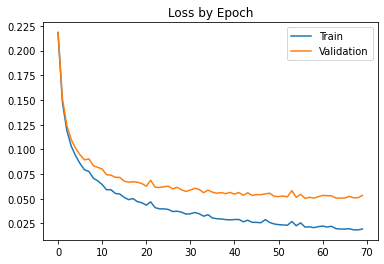

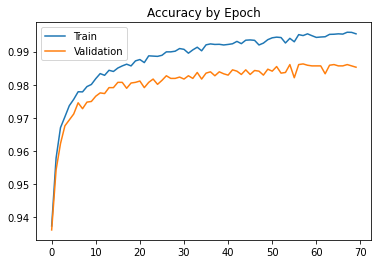

<Figure size 432x288 with 0 Axes>

In [ ]:
train_results = execute_train_pipeline(question_no=1, model_num=10, test=False)

In [ ]:
mistakes, mistake_imgs, lbl_list, pred_list, X_test = execute_train_pipeline(question_no=1, model_num=10, test=True)

Testing completed! Saving results now...
tensor(0.9858, device='cuda:0')
tensor(0.0472, device='cuda:0')
             T-shirt/top  Trouser  Coat  Sandal  Bag
T-shirt/top          971        4    11       3   11
Trouser                3      988     7       0    2
Coat                   6        2   989       1    2
Sandal                 0        1     0     999    0
Bag                    8        2     4       4  982
          T-shirt/top  Trouser  Coat  Sandal   Bag
Accuracy         97.1     98.8  98.9    99.9  98.2
{   'best_epoch_train_accuracy': array(0.9951151, dtype=float32),
    'best_epoch_train_loss': array(0.02129077, dtype=float32),
    'best_epoch_val_accuracy': array(0.9860697, dtype=float32),
    'best_epoch_val_loss': array(0.05038992, dtype=float32),
    'best_val_epoch': 56,
    'final_train_accuracy': tensor(0.9951),
    'final_train_loss': tensor(0.0213),
    'final_val_accuracy': tensor(0.9861),
    'final_val_loss': tensor(0.0504)}


In [ ]:
'''
{   'best_epoch_train_accuracy': array(0.99499494, dtype=float32),
    'best_epoch_train_loss': array(0.02142712, dtype=float32),
    'best_epoch_val_accuracy': array(0.98527366, dtype=float32),
    'best_epoch_val_loss': array(0.05036554, dtype=float32),
    'best_val_epoch': 56,
    'final_train_accuracy': tensor(0.9952),
    'final_train_loss': tensor(0.0195),
    'final_val_accuracy': tensor(0.9861),
    'final_val_loss': tensor(0.0510)}
'''

tensor([[[[ 0.,  0.,  0.,  ...,  0.,  0.,  0.],
          [ 0.,  0.,  0.,  ...,  0.,  0.,  0.],
          [ 0.,  0.,  0.,  ...,  0.,  0.,  0.],
          ...,
          [ 0.,  0.,  0.,  ...,  0.,  0.,  0.],
          [ 0.,  0.,  0.,  ...,  0.,  0.,  0.],
          [ 0.,  0.,  0.,  ...,  0.,  0.,  0.]]],


        [[[ 0.,  0.,  0.,  ...,  0.,  0.,  0.],
          [ 0.,  0.,  0.,  ...,  0.,  0.,  0.],
          [ 0.,  0.,  0.,  ...,  0.,  0.,  0.],
          ...,
          [ 0.,  0.,  0.,  ...,  0.,  0.,  0.],
          [ 0.,  0.,  0.,  ...,  0.,  0.,  0.],
          [ 0.,  0.,  0.,  ...,  0.,  0.,  0.]]],


        [[[ 0.,  0.,  0.,  ...,  0.,  0.,  0.],
          [ 0.,  0.,  0.,  ...,  0.,  0.,  0.],
          [ 1.,  0.,  0.,  ...,  1.,  0.,  0.],
          ...,
          [ 0.,  0., 43.,  ...,  0.,  0.,  4.],
          [ 2.,  0.,  0.,  ...,  0.,  3.,  0.],
          [ 0.,  0.,  0.,  ...,  0.,  0.,  0.]]],


        ...,


        [[[ 0.,  0.,  0.,  ...,  0.,  0.,  0.],
          [ 0., 

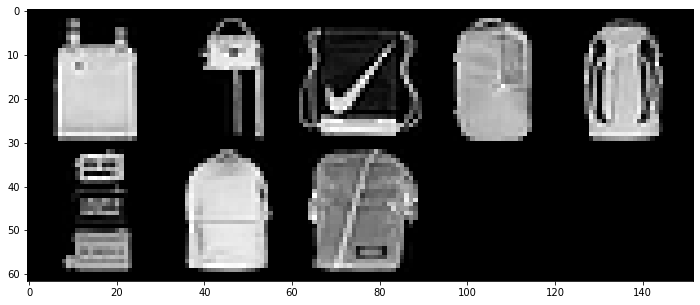

In [ ]:
get_confusion_indices(lbl_list, pred_list, X_test, 4, 0)

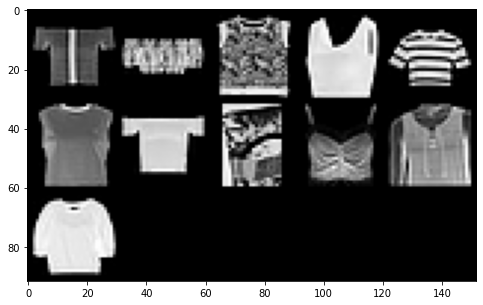

In [ ]:
X_confusion = get_confusion_indices(lbl_list, pred_list, X_test, 0, 4)

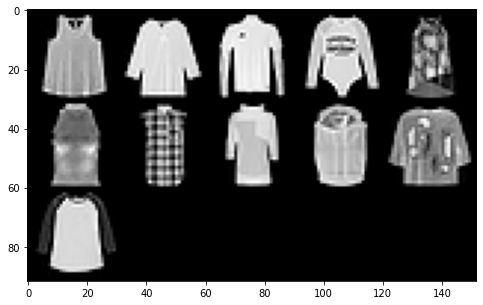

In [ ]:
X_confusion = get_confusion_indices(lbl_list, pred_list, X_test, 0, 2)

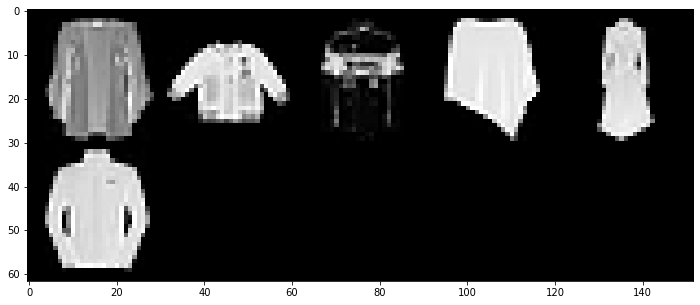

In [ ]:
X_confusion = get_confusion_indices(lbl_list, pred_list, X_test, 2, 0)